# Data Understanding

This notebook is a proof-of-concept on finding out the exact specifications of the data that we wish to operate on. This step has several goals:
- Find out the data specification
- Find the best data representation for our deep learning model
- ???.

## Constants

| Constants            | Value |
|----------------------|---     |
| Sample rate          | 8000 |
| Image height         | 500|
| Image width (window) | 157   |
| Window length        | SAMPLE_RATE * 10 |

In [1]:
import os

# CONSTANTS
DATASET_DIR = '../data'
SAMPLE_RATE = 16000 # 8 kHz sample rate; we downsample because we want 4KHz — making the model more robust against noise in the higher frequencies.
IMAGE_HEIGHT = 500
IMAGE_WIDTH = 157
SPLIT_SECOND = 10 # second
WAVE_SAMPLE_LENGTH = int(SAMPLE_RATE * 0.25)
SAMPLE_LENGTH = SAMPLE_RATE * SPLIT_SECOND

## Dialects

Per the dialects retrieved from Max Planck Institute's EVA Jakarta Field Station, we have these dialects:
- Ngadas
- Banten
- Tengger
- Semarang
- Madiun
- Tegal
- Banyumas
- Papua
- Lumajang
- Solo
- Pemalang
- Cirebon
- Kediri
- Malang
- Osing
- Ranu Pane

In [2]:
dialects = os.listdir('../data/audio/')
dialects

['Ngadas',
 'Banten',
 'Tengger',
 'Semarang',
 'Madiun',
 'Tegal',
 'Banyumas',
 'Papua',
 'Lumajang',
 'Solo',
 'Pemalang',
 'Cirebon',
 'Kediri',
 'Malang',
 'Osing',
 'Ranu Pane']

## Audio Loading

In [3]:
from pathlib import Path

wavs = dict()
for dialect in dialects:
    wavs[dialect] = [wav for wav in os.listdir(Path('../data/audio') / dialect) if wav[-3:] == 'wav']

wavs

{'Ngadas': ['Marsam.wav', 'Mas_Tom_Ngadas_201102.wav'],
 'Banten': ['JWBP-20121229-A.wav',
  'JWBA-20100703-a.wav',
  'JWB-Banten_9.wav',
  'banten-2010-07-02-a.wav',
  'JWB-20090125.wav',
  'JWBP-20121229-B.wav',
  'JWB-Banten_10.wav',
  'JWB-20090126.wav',
  'JWB-20090116.wav',
  'JWB-Banten20100605-B.wav',
  'JWB-Banten_1.wav',
  'JWB-Banten_6.wav',
  'JWBA-20100703-b.wav',
  'JWB-Banten_4.wav',
  'JWB-20090117.wav',
  'JWB-20090118.wav',
  'JWB-Banten_8.wav',
  'JWB-20090131.wav',
  'JWB-20090130.wav',
  'JWB-Banten_11.wav',
  'JWB-Banten_5.wav',
  'JWB-20090123.wav',
  'JWB-20090124.wav',
  'JWB-20090127.wav',
  'JWB-Banten_19.wav',
  'JWB-Banten20100605-A.wav',
  'JWB-Banten_7.wav',
  'JWB-Banten_3.wav',
  'JWB-Banten_2.wav',
  'JWB-20090120.wav',
  'JWB-20090122.wav',
  'JWB-20070129.wav',
  'JWBS-20100702-b.wav'],
 'Tengger': ['Ngadisari.wav', 'Wonokitri.wav'],
 'Semarang': ['JCM-20080114.wav', 'JCM-20080115.wav'],
 'Madiun': ['Madiun.wav',
  'Madiun-20080125-Marpuah.wav',
  'J

In [4]:
# Loading our example audio
import librosa

_ = librosa.load(
    "../data/audio/Ngadas/Mas_Tom_Ngadas_201102.wav",
    sr=SAMPLE_RATE,
    mono=True,
    res_type='soxr_vhq'
)[0]
_segment = _[SAMPLE_LENGTH:SAMPLE_LENGTH + SAMPLE_LENGTH]

In [5]:
print(_segment)
print(_segment.shape)

[ 0.00366144  0.01288834  0.01554883 ... -0.00289218  0.00031064
  0.00213397]
(160000,)


## Waveform

In [6]:
from matplotlib import pyplot as plt
from librosa import display

plt.figure(figsize=(20,5))
librosa.display.waveplot(_segment, sr=SAMPLE_RATE)
plt.savefig('../visualization/_segment.png')
plt.show()

## Pre-emphasis

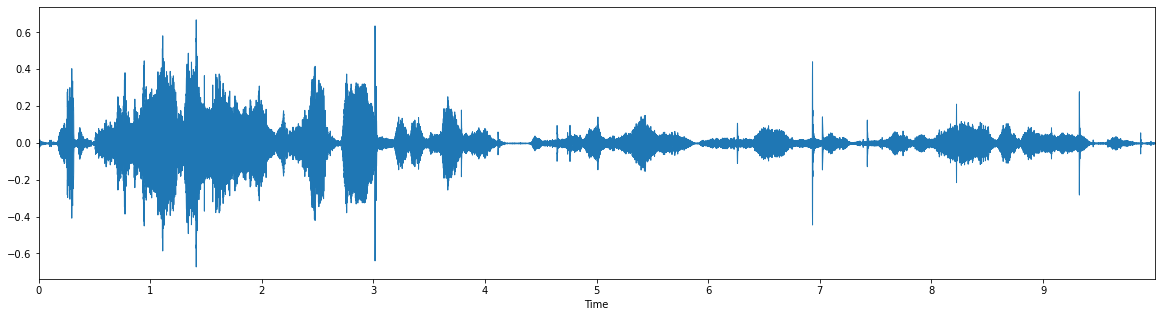

In [ ]:
import numpy as np

PRE_EMPHASIS_ALPHA = 0.97
_segment_emphasized = np.append(_segment[0], _segment[1:] - PRE_EMPHASIS_ALPHA * _segment[:-1])

plt.figure(figsize=(20,5))
librosa.display.waveplot(_segment_emphasized, SAMPLE_RATE)
plt.savefig('../visualization/_segment_emphasized.png')
plt.show()

In [ ]:
from scipy.io import wavfile

wavfile.write('../data/Mas_Tom_Ngadas_201102-segment.wav', SAMPLE_RATE, _segment)
wavfile.write('../data/Mas_Tom_Ngadas_201102-segment-emphasized.wav', SAMPLE_RATE, _segment_emphasized)

In [ ]:
_emphasized = np.append(_[0], _[1:] - PRE_EMPHASIS_ALPHA * _[:-1])

# Setting emphasized as default?
_segment = _segment_emphasized
_ = _emphasized

## Voice Activity Detection

In [ ]:
import numpy as np

def voice_activity_detection(input, feature=None):
    if feature is not None:
        frame_length = FRAME_SIZE_SAMPLE
        hop_length = FRAME_STRIDE_SAMPLE
    else:
        frame_length = 1
        hop_length = 1
    _rmse = librosa.feature.rms(input, frame_length=frame_length, hop_length=hop_length)
    _threshold = np.mean(_rmse) / 2 * 1.04  # credits to Shon et al. (2018)
    _mask = np.nonzero(_rmse > _threshold)[1]
    if feature is not None:
        return input[:, _mask]
    return input[_mask]

In [ ]:
import numpy as np

# Voice Activity Detection - courtesy of Shon et al., (2018)
_segment_rmse = librosa.feature.rms(_segment, frame_length=1, hop_length=1)
_segment_threshold = np.mean(_segment_rmse) / 2 * 1.04
# _segment_vad_segments = np.nonzero(_segment_rmse > _segment_threshold)
_segment_mask = _segment_rmse > _segment_threshold

In [ ]:
print(_segment_rmse > _segment_threshold)

[[False False False ... False False False]]


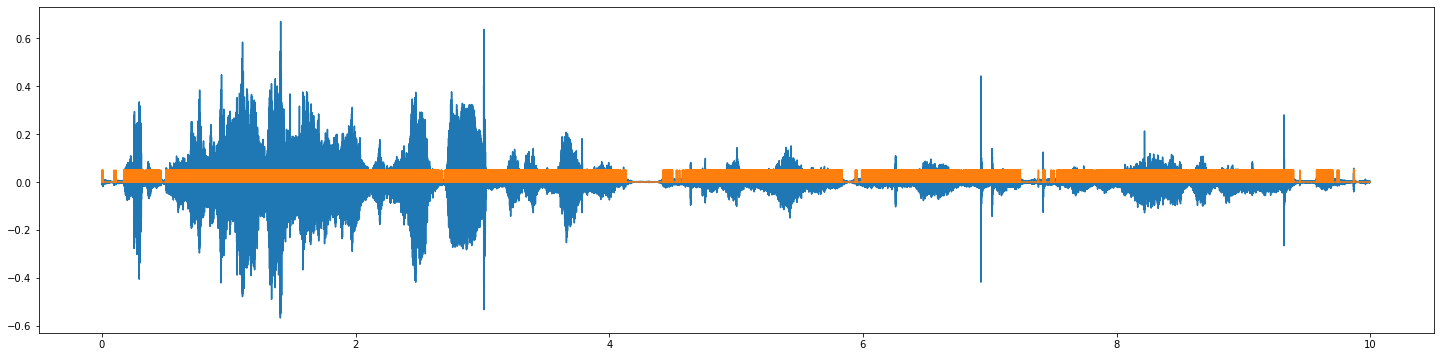

In [ ]:
# Visualization
t = np.linspace(
    0,
    _segment.shape[0] / SAMPLE_RATE,
    _segment.shape[0])
plt.figure(figsize=(25, 6))
plt.plot(t, _segment)
plt.plot(t, [0.05 if d else 0 for d in _segment_mask[0]])
plt.savefig('../visualization/_segment_vad.svg')
plt.show()

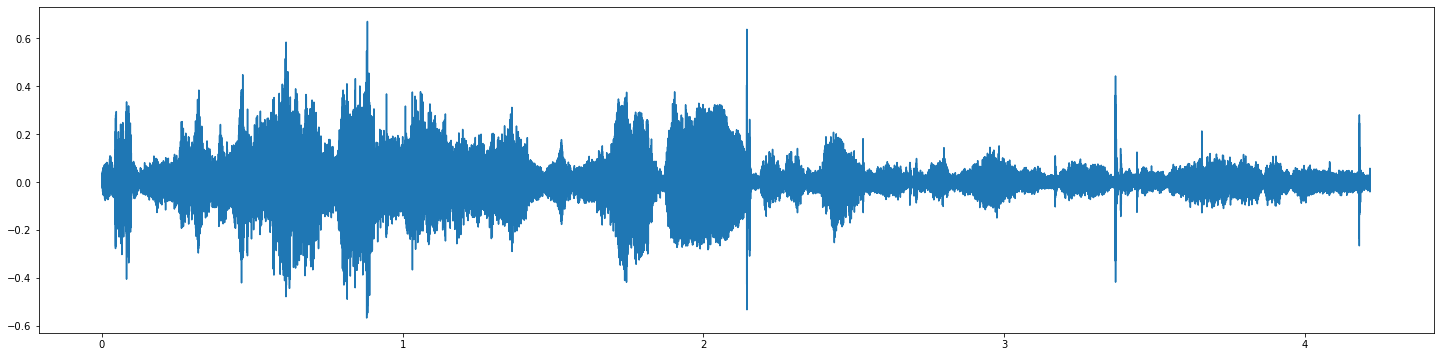

In [ ]:
_segment_desilenced = voice_activity_detection(_segment, feature=None)
t_desilenced = np.linspace(
    0, 
    _segment_desilenced.shape[0] / SAMPLE_RATE,
    _segment_desilenced.shape[0]
) 

plt.figure(figsize=(25, 6))
plt.plot(t_desilenced, _segment_desilenced)
plt.show()

In [ ]:
_desilenced = voice_activity_detection(_, feature=None)

## Frequency filtering

### Low-pass filter (Butter)
- Sample period: 25ms
- Sample rate: SAMPLE_RATE (16kHz)
- Total samples: 0.025 seconds * 16 kHz = 400 (sec * 1/sec)
- Signal frequency cutoff: 4 kHz
- Nyquist Frequency: SAMPLE_RATE/2 = 8 kHz
- Order: adjusting (ideal: 6?)

In [ ]:
# Creating a low-pass filter up to 4 kHz
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

order = 6
fs = SAMPLE_RATE
cutoff = 4000
nyquist = 0.5 * fs

b, a = butter_lowpass(cutoff, fs, order)

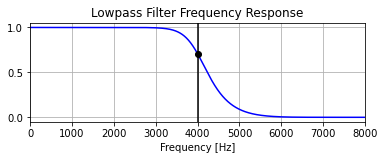

In [ ]:
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, nyquist)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [ ]:
b

array([0.02958822, 0.17752934, 0.44382335, 0.59176447, 0.44382335,
       0.17752934, 0.02958822])

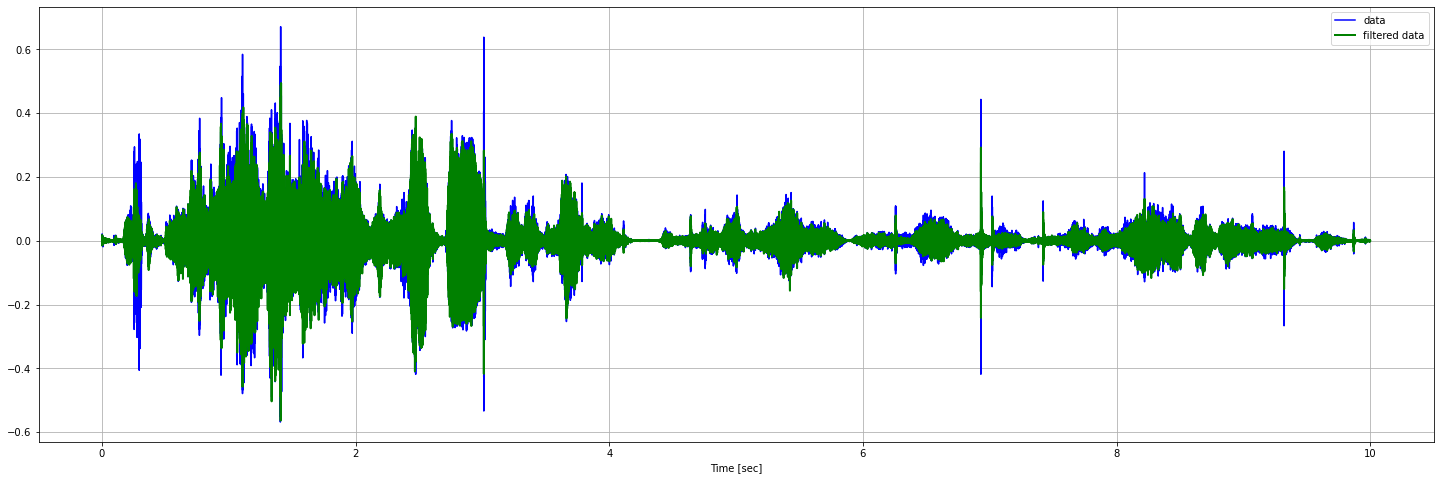

In [ ]:
_segment_filtered = butter_lowpass_filter(_segment, cutoff, fs, order)

T = SPLIT_SECOND
n = int(SPLIT_SECOND * SAMPLE_RATE)
t = np.linspace(0, T, n, endpoint=False)

plt.figure(figsize=(25, 8))
plt.plot(t, _segment, 'b-', label='data')
plt.plot(t, _segment_filtered, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.savefig('../visualization/_segment_filtered_low.svg')
plt.show()

/home/vin/miniconda3/lib/python3.8/site-packages/librosa/util/utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


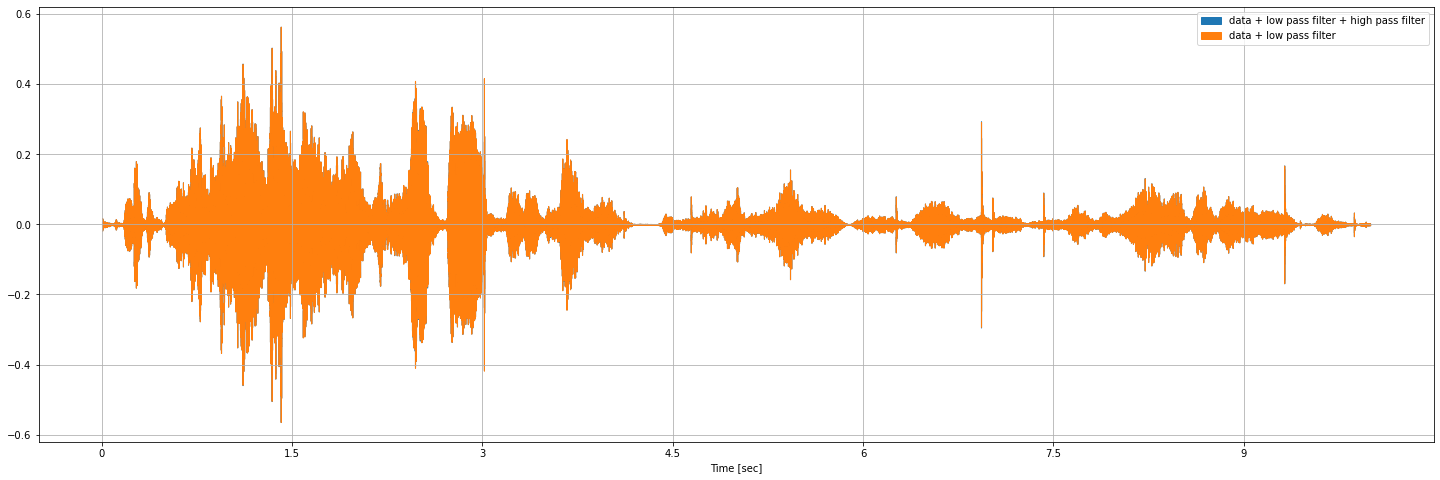

In [ ]:
from scipy.signal import filtfilt

# High-pass filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

_segment_filtered_2 = butter_highpass_filter(_segment_filtered, 200, fs, order)

plt.figure(figsize=(25, 8))
librosa.display.waveshow(_segment_filtered_2, sr=SAMPLE_RATE, x_axis='time', label='data + low pass filter + high pass filter')
librosa.display.waveshow(_segment_filtered, sr=SAMPLE_RATE, x_axis='time', label='data + low pass filter')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

/home/vin/miniconda3/lib/python3.8/site-packages/librosa/util/utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


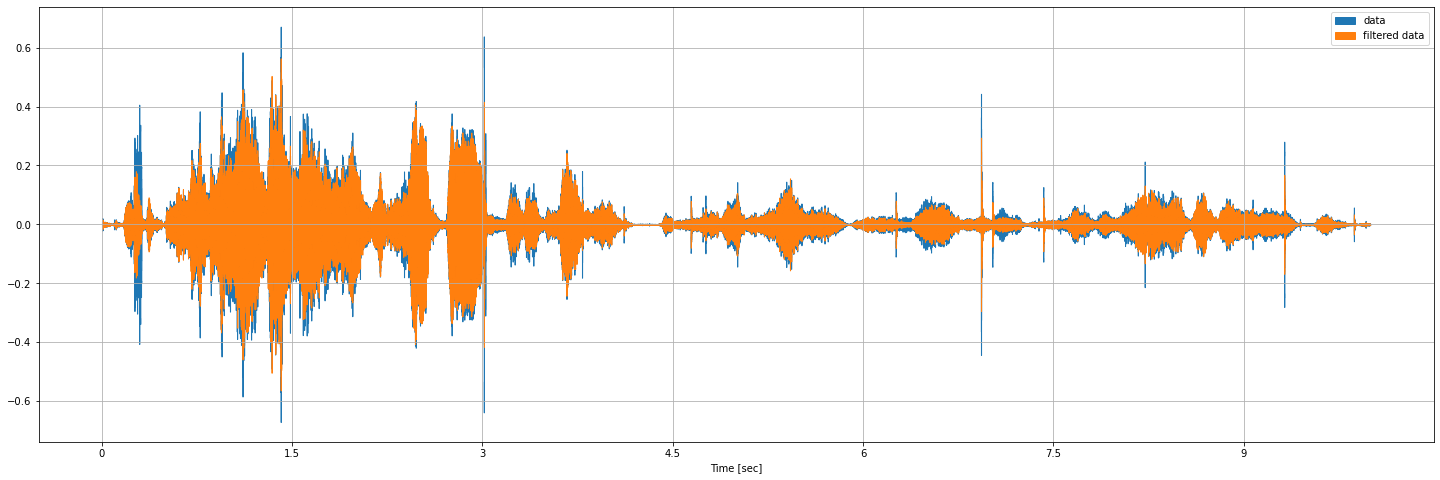

In [ ]:
plt.figure(figsize=(25, 8))
librosa.display.waveshow(_segment, sr=SAMPLE_RATE, x_axis='time', label='data')
librosa.display.waveshow(_segment_filtered_2, sr=SAMPLE_RATE, x_axis='time', label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.savefig('../visualization/_segment_filtered.svg')
plt.show()

In [ ]:
_filtered = butter_lowpass_filter(_, cutoff, fs, order)
_filtered = butter_highpass_filter(_filtered, 200, fs, order)

## Features

### Mel Spectrogram

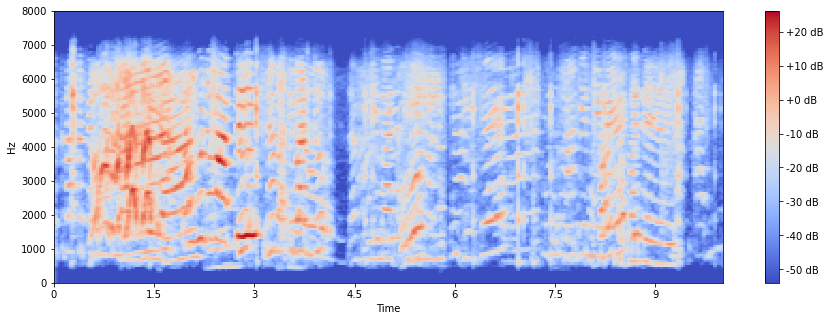

In [ ]:
# Audio Mel Spectrogram - raw
_segment_mel_spectrogram = librosa.feature.melspectrogram(_segment_filtered_2, sr=SAMPLE_RATE)
_segment_mel_spectrogram_image = librosa.core.power_to_db(_segment_mel_spectrogram)

plt.figure(figsize=(15, 5))
librosa.display.specshow(_segment_mel_spectrogram_image, sr=SAMPLE_RATE, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.savefig('../visualization/mel_spec.png')
plt.show()

In [ ]:
_segment_mel_spectrogram.shape

(128, 313)

In [ ]:
(SAMPLE_RATE * 10)

160000

In [ ]:
(SAMPLE_RATE * 0.025)

400.0

In [ ]:
# FFT window size (25ms)
(SAMPLE_RATE * 10) / (SAMPLE_RATE * 0.025)

400.0

In [ ]:
# Stride size (15ms)
(SAMPLE_RATE * 0.015)

240.0

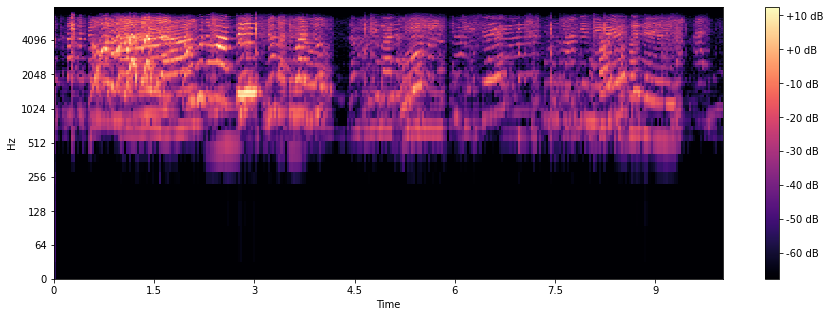

In [ ]:
FRAME_SIZE_SECOND = 0.025
FRAME_SIZE = int(SAMPLE_RATE * FRAME_SIZE_SECOND)

_segment_mel_spectrogram = librosa.feature.melspectrogram(_segment_filtered_2, sr=SAMPLE_RATE, n_fft=FRAME_SIZE)
_segment_mel_spectrogram_image = librosa.core.power_to_db(_segment_mel_spectrogram)

plt.figure(figsize=(15, 5))
librosa.display.specshow(_segment_mel_spectrogram_image, sr=SAMPLE_RATE, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.savefig('../visualization/mel_spec_25ms.png')
plt.show()

In [ ]:
_segment.shape

(160000,)

In [ ]:
_segment.shape[0] / SAMPLE_RATE

10.0

In [ ]:
_segment_mel_spectrogram.shape

(128, 313)

240


/home/vin/miniconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:1559: RuntimeWarning: divide by zero encountered in log10
  log_spec = 10.0 * np.log10(np.maximum(amin, magnitude))


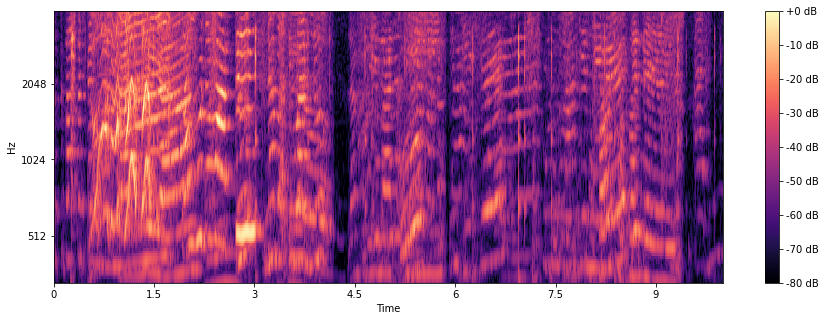

In [ ]:
FRAME_STRIDE_SECOND = 0.015
FRAME_STRIDE = int(SAMPLE_RATE * FRAME_STRIDE_SECOND)
print(FRAME_STRIDE)

MEL_AMOUNT = 128

_segment_mel_spectrogram = librosa.feature.melspectrogram(
    _segment,
    sr=SAMPLE_RATE,
    win_length=FRAME_SIZE,
    hop_length=FRAME_STRIDE,
    n_mels=MEL_AMOUNT,
    fmin=200,
    fmax=4000,
    dtype=np.float16
).astype(np.float16)
_segment_mel_spectrogram_image = librosa.core.power_to_db(_segment_mel_spectrogram, ref=np.max)

plt.figure(figsize=(15, 5))
librosa.display.specshow(_segment_mel_spectrogram_image, sr=SAMPLE_RATE, hop_length=FRAME_STRIDE, x_axis='time', y_axis='mel', fmin=200, fmax=4000)
plt.colorbar(format='%+2.0f dB')

plt.savefig('../visualization/mel_spec_25ms_stride15ms.svg')
plt.show()

In [ ]:
_segment_mel_spectrogram.dtype

dtype('float16')

In [ ]:
from pympler.asizeof import asizeof
print(f"Size: {asizeof(_segment_mel_spectrogram) / 1e3} KB")

Size: 170.888 KB


In [ ]:
_segment_mel_spectrogram.shape

(128, 667)

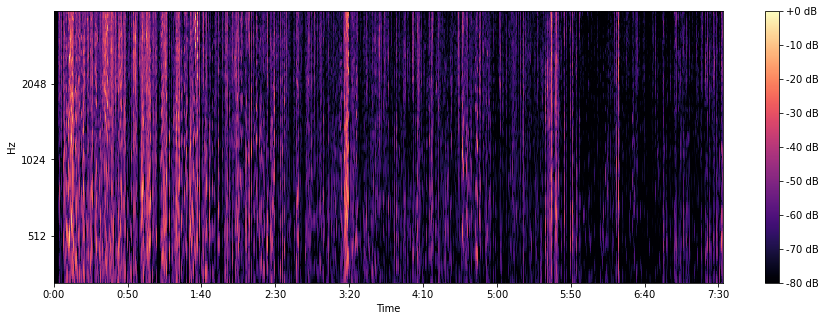

In [ ]:
_mel_spectrogram = librosa.feature.melspectrogram(
    _,
    sr=SAMPLE_RATE,
    win_length=FRAME_SIZE,
    hop_length=FRAME_STRIDE,
    n_mels=MEL_AMOUNT,
    fmin=200,
    fmax=4000,
    dtype=np.float16
).astype(np.float16)

plt.figure(figsize=(15, 5))
librosa.display.specshow(librosa.core.power_to_db(_mel_spectrogram, ref=np.max), sr=SAMPLE_RATE, hop_length=266, x_axis='time', y_axis='mel', fmin=200, fmax=4000)
plt.colorbar(format='%+2.0f dB')

plt.show()

In [ ]:
_mel_spectrogram.shape

(128, 27264)

### Frequency Spectrogram

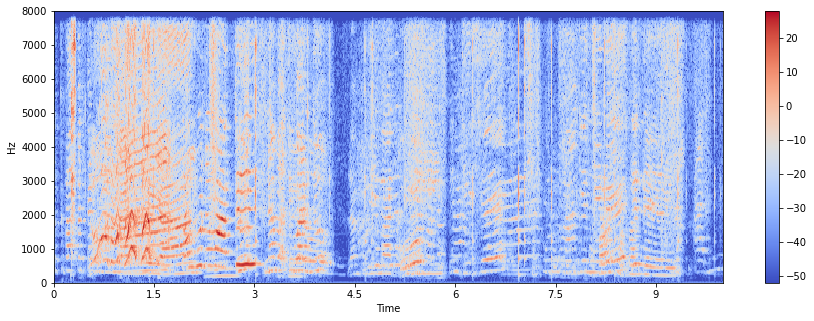

In [ ]:
# Spectrogram
win_length = 256

_segment_spectrogram = librosa.core.stft(_segment, n_fft=FRAME_SIZE, hop_length=FRAME_STRIDE)
_segment_spectrogram_db = librosa.amplitude_to_db(abs(_segment_spectrogram))

plt.figure(figsize=(15, 5))
librosa.display.specshow(_segment_spectrogram_db, sr=SAMPLE_RATE, hop_length=FRAME_STRIDE, x_axis='time', y_axis='hz')
plt.colorbar()

plt.savefig('../visualization/spec.png')
plt.show()

In [ ]:
_segment_spectrogram.shape

(201, 667)

/home/vin/miniconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:1559: RuntimeWarning: divide by zero encountered in log10
  log_spec = 10.0 * np.log10(np.maximum(amin, magnitude))


(190, 667)


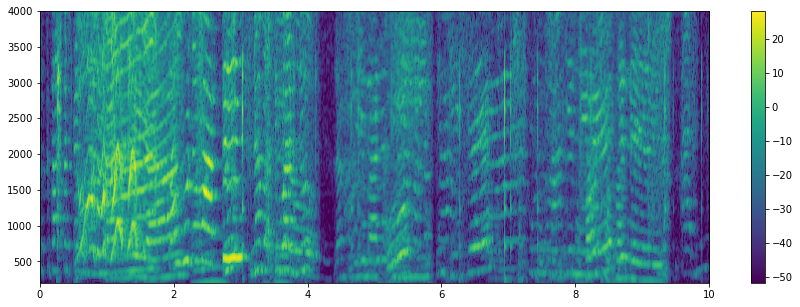

In [ ]:
LOWER_BOUND = 200 // 20
UPPER_BOUND = 4000 // 20

_segment_spectrogram = np.abs(
    librosa.core.stft(
        _segment,
        win_length=FRAME_SIZE,
        hop_length=FRAME_STRIDE,
        n_fft=800
    )
)[LOWER_BOUND:UPPER_BOUND, :].astype(np.float16)
_segment_spectrogram_db = librosa.amplitude_to_db(_segment_spectrogram, ref=np.max)

print(_segment_spectrogram.shape)

plt.figure(figsize=(15, 5))
# librosa.display.specshow(_segment_spectrogram_db, sr=SAMPLE_RATE, hop_length=FRAME_STRIDE, x_axis='time', y_axis='hz')
plt.imshow(_segment_spectrogram_db, aspect='auto', origin='lower', extent=[0, 10, 200, 4000], cmap='viridis')
# plt.specgram(_segment_spectrogram_db, Fs=SAMPLE_RATE, NFFT=380, xextent=[200, 4000])
plt.colorbar()
plt.savefig('../visualization/spec_stft.svg')
plt.show()

In [ ]:
_segment_spectrogram.dtype

dtype('float16')

### Spectrogram (log-adjusted)

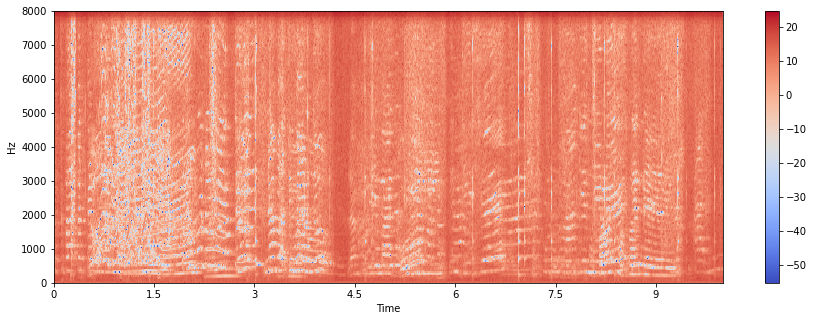

In [ ]:
# Spectrogram - log-adjusted
import numpy as np

# _spectrogram_log_db = cp.log(cp.abs(cp.asarray(_spectrogram)))
# _spectrogram_log = librosa.core.stft(_segment, n_fft=256, win_length=win_length, hop_length=hop)
# _spectrogram_log_db = librosa.amplitude_to_db(cp.log(cp.abs(cp.asarray(_spectrogram))).get())
_segment_spectrogram_log_db = librosa.amplitude_to_db(np.log(np.abs(_segment_spectrogram)))

plt.figure(figsize=(15, 5))
librosa.display.specshow(_segment_spectrogram_log_db, sr=SAMPLE_RATE, hop_length=FRAME_STRIDE, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

### Comparison

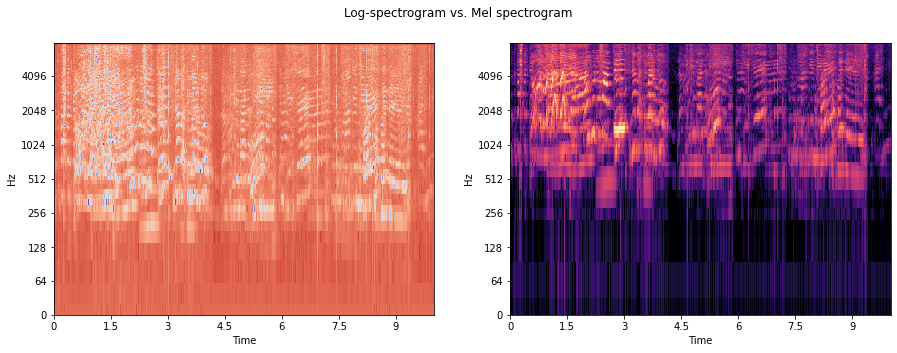

In [ ]:
# Log spectrogram vs. Mel spectrogram
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Log-spectrogram vs. Mel spectrogram')
librosa.display.specshow(_segment_spectrogram_log_db, sr=SAMPLE_RATE, x_axis='time', y_axis='log', hop_length=FRAME_STRIDE, ax=ax[0])
librosa.display.specshow(_segment_mel_spectrogram_image, sr=SAMPLE_RATE, hop_length=FRAME_STRIDE, x_axis='time', y_axis='log', ax=ax[1])
plt.savefig('../visualization/comparison_log_mel_spec.svg')
plt.show()

## Mel Frequency Cepstrum Coefficient

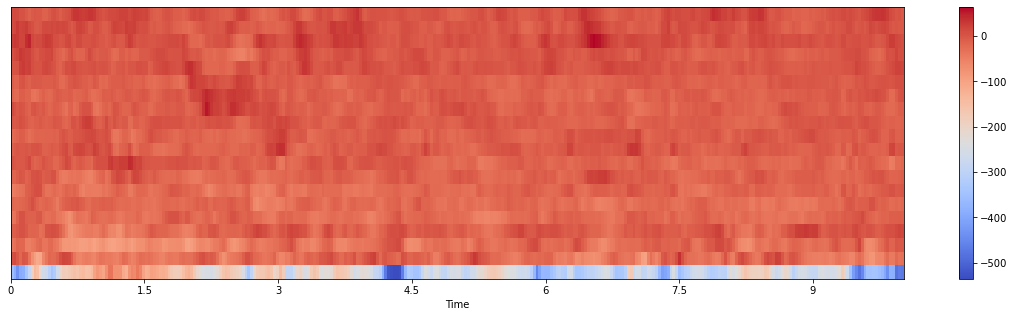

In [44]:
_segment_mfcc = librosa.feature.mfcc(_segment, sr=SAMPLE_RATE)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_segment_mfcc, sr=SAMPLE_RATE, x_axis='time')
plt.colorbar()

plt.savefig('../visualization/mfcc.png')
plt.show()

In [30]:
_segment_mfcc.shape

(20, 313)

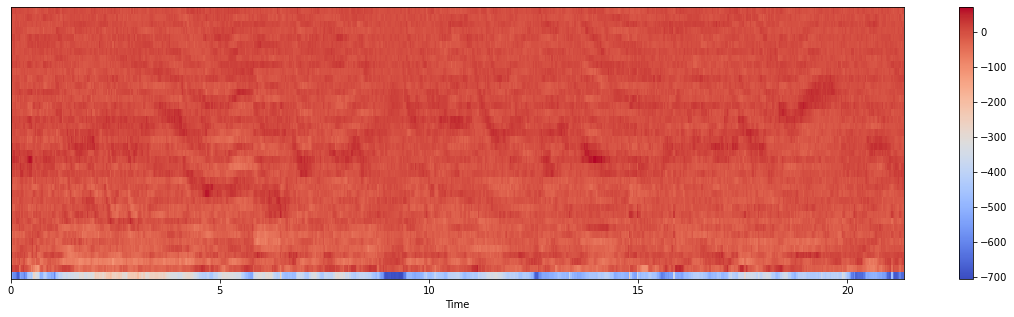

In [45]:
_segment_mfcc = librosa.feature.mfcc(_segment, sr=SAMPLE_RATE, n_fft=FRAME_SIZE, n_mfcc=40, hop_length=FRAME_STRIDE)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_segment_mfcc, sr=SAMPLE_RATE, x_axis='time')
plt.colorbar()

plt.savefig('../visualization/mfcc_shon2018.png')
plt.show()

In [32]:
_segment_mfcc.shape

(40, 667)

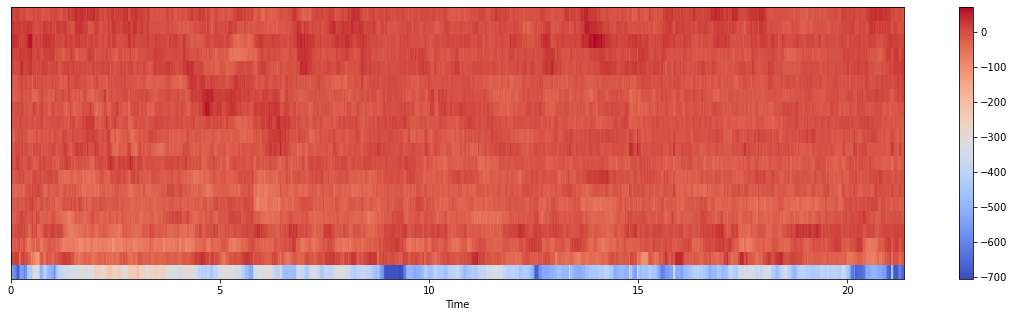

In [46]:
# MFCC from Mel spectrogram

_segment_mfcc_from_mel_spectrogram = librosa.feature.mfcc(S=_segment_mel_spectrogram_image)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_segment_mfcc_from_mel_spectrogram, sr=SAMPLE_RATE, x_axis='time')
plt.colorbar()

plt.savefig('../visualization/mfcc_from_spectrogram.png')
plt.show()

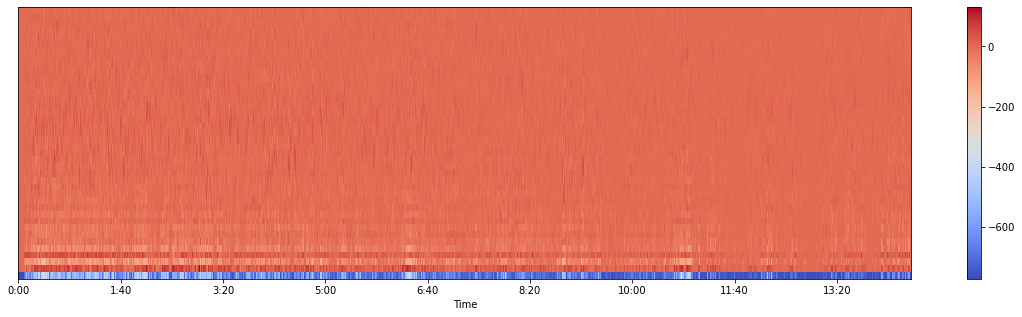

In [51]:
_mfcc = librosa.feature.mfcc(_filtered, sr=SAMPLE_RATE, n_fft=FRAME_SIZE, n_mfcc=40, hop_length=FRAME_STRIDE)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_mfcc, sr=SAMPLE_RATE, x_axis='time')
plt.colorbar()
plt.show()

In [ ]:
librosa.feature.mfcc(
        _desilenced,
        sr=SAMPLE_RATE,
        n_mfcc=MFCC_AMOUNT,
        n_fft=FRAME_SIZE_SAMPLE,
        hop_length=FRAME_STRIDE_SAMPLE,
        fmin=F_MIN,
        fmax=F_MAX)

## Comparison
### Normal and silenced

In [ ]:
# Comparison
fig, ax = plt.subplots(2, figsize=(20, 10))
fig.suptitle('Comparison between raw (top) and desilenced (bottom) Mel Spectrogram')
librosa.display.specshow(librosa.core.power_to_db(_mel_spectrogram), sr=SAMPLE_RATE, x_axis='time', y_axis='log', ax=ax[0])
smth = librosa.display.specshow(librosa.core.power_to_db(_mel_spectrogram_vad), sr=SAMPLE_RATE, x_axis='time', y_axis='log', ax=ax[1])
fig.colorbar(smth, ax=ax)
plt.show()

### Functions

In [ ]:
# Windowing and Gating

# def filter_noise(wave):
#     _rms = librosa.feature.rms(wave, frame_length=400, hop_length=wave.shape[0] // IMAGE_WIDTH)
#     _threshold = np.mean(_rms) / 2 * 1.04
#     _mask = np.nonzero(_rms > _threshold)[1]
#     return wave[:, _mask]

def split_second(wave, second=10, sr=SAMPLE_RATE):
    wave_windows = list()
    l = 0
    r = second * sr
    while r < wave.shape[0]:
        wave_windows.append(wave[l:r])
        print(l, r, r/sr)
        l += second * sr
        r = r + second * sr if r + second * sr < wave.shape[0] else wave.shape[0]
    wave_windows.append(wave[l:r])
    print('Done at', l, r)
    return wave_windows

def desilence(wave, feature):
    _rms = librosa.feature.rms(wave, frame_length=400)
    _threshold = np.mean(_rms) / 2 * 1.04
    _mask = np.nonzero(_rms > _threshold)[1]

    return feature[:, _mask]

In [ ]:
_split = split_second(_)

0 80000 10.0
80000 160000 20.0
160000 240000 30.0
240000 320000 40.0
320000 400000 50.0
400000 480000 60.0
480000 560000 70.0
560000 640000 80.0
640000 720000 90.0
720000 800000 100.0
800000 880000 110.0
880000 960000 120.0
960000 1040000 130.0
1040000 1120000 140.0
1120000 1200000 150.0
1200000 1280000 160.0
1280000 1360000 170.0
1360000 1440000 180.0
1440000 1520000 190.0
1520000 1600000 200.0
1600000 1680000 210.0
1680000 1760000 220.0
1760000 1840000 230.0
1840000 1920000 240.0
1920000 2000000 250.0
2000000 2080000 260.0
2080000 2160000 270.0
2160000 2240000 280.0
2240000 2320000 290.0
2320000 2400000 300.0
2400000 2480000 310.0
2480000 2560000 320.0
2560000 2640000 330.0
2640000 2720000 340.0
2720000 2800000 350.0
2800000 2880000 360.0
2880000 2960000 370.0
2960000 3040000 380.0
3040000 3120000 390.0
3120000 3200000 400.0
3200000 3280000 410.0
3280000 3360000 420.0
3360000 3440000 430.0
3440000 3520000 440.0
3520000 3600000 450.0
3600000 3680000 460.0
3680000 3760000 470.0
3760000

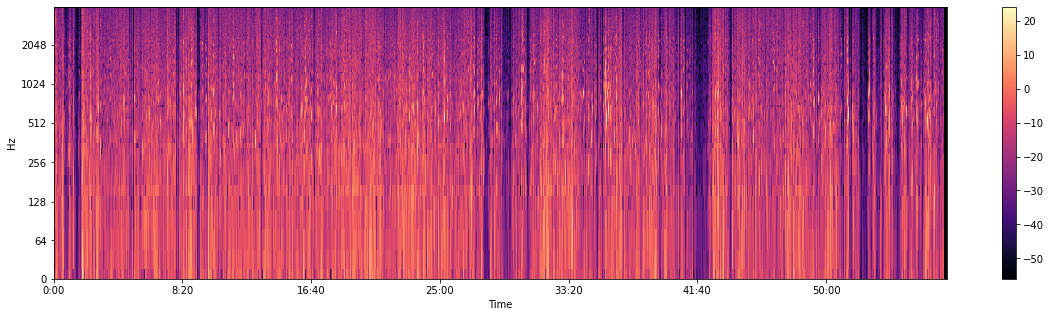

In [ ]:
_mel_spectrogram = librosa.feature.melspectrogram(_, sr=SAMPLE_RATE, n_fft=400, fmin=200, fmax=4000)

plt.figure(figsize=(20, 5))
librosa.display.specshow(librosa.core.power_to_db(_mel_spectrogram), sr=SAMPLE_RATE, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

In [ ]:
_mel_spectrogram.shape

(128, 54180)

In [ ]:
_desilenced = desilence(_, _mel_spectrogram)
_desilenced.shape

(128, 40716)

In [ ]:
_mel_spectrogram.shape

(128, 54180)

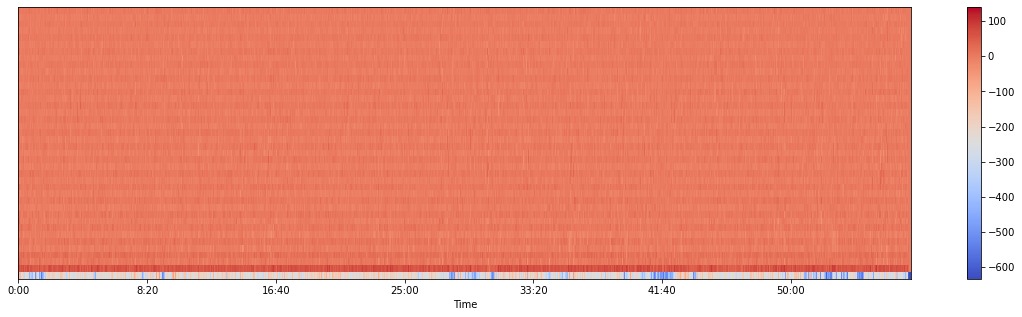

In [43]:
# MFCC - Full
_mfcc = librosa.feature.mfcc(_, sr=SAMPLE_RATE, n_mfcc=40, n_fft=400, fmin=200, fmax=4000)

plt.figure(figsize=(20, 5))
librosa.display.specshow(_mfcc, sr=SAMPLE_RATE, x_axis='time')

plt.colorbar()
plt.show()

In [44]:
_mfcc.shape

(40, 54180)

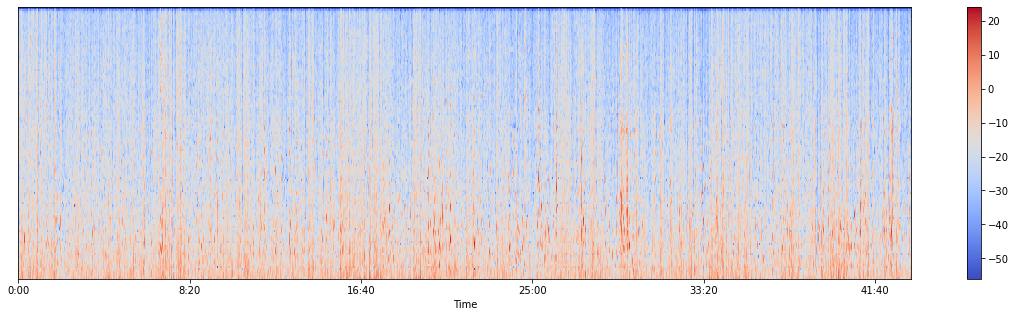

In [45]:
# Voice Activity Detection on full WAV
_mel_spectrogram_desilenced = desilence(_, _mel_spectrogram)

plt.figure(figsize=(20, 5))
librosa.display.specshow(librosa.core.power_to_db(_mel_spectrogram_desilenced), sr=SAMPLE_RATE, x_axis='time')

plt.colorbar()
plt.show()

In [46]:
_mel_spectrogram_desilenced.shape

(128, 40716)

In [47]:
# Saving test
np.savetxt('../dataset/mel_spectrogram_test', _mel_spectrogram)

In [48]:
_load_file_test = np.loadtxt('../dataset/mel_spectrogram_test')

In [49]:
_load_file_test.shape

(128, 54180)

In [50]:
_mel_spectrogram.dtype

dtype('float32')

In [51]:
_mel_spectrogram.shape

(128, 54180)

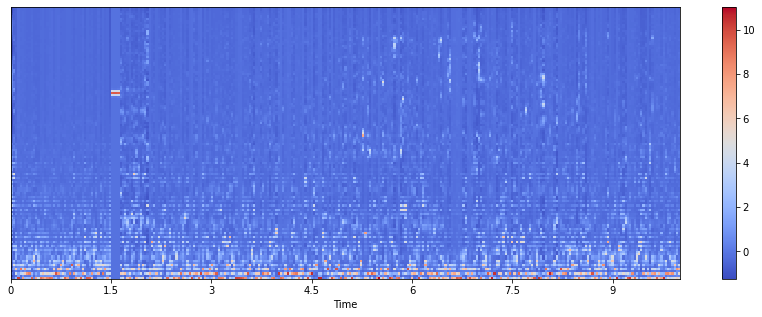

In [52]:
# Testing the Cepstral Mean Variance Normalisation function and visualising the result
from medhok import preprocessing as pre
# import math

# threads_per_block=256
# blocks_per_grid=math.ceil(_segment_mel_spectrogram.shape[1] / threads_per_block)
_segment_mel_spectrogram_normalised = pre.normalise_feature(_segment_mel_spectrogram)

plt.figure(figsize=(15, 5))
librosa.display.specshow(_segment_mel_spectrogram_normalised, sr=SAMPLE_RATE, x_axis='time', hop_length=HOP_LENGTH)
plt.colorbar()

plt.show()

In [53]:
_segment_mel_spectrogram[:, 0]

array([5.17427397e-04, 7.59638278e-05, 7.61758653e-04, 1.05887251e-04,
       7.91125000e-04, 2.25438125e-04, 7.46690959e-04, 3.80440615e-04,
       7.00743403e-04, 5.62350149e-04, 6.29456830e-04, 7.69746141e-04,
       5.30897814e-04, 1.01778784e-03, 4.12107329e-04, 1.33964559e-03,
       2.70961173e-04, 1.66226574e-03, 2.14692671e-04, 1.68802473e-03,
       3.69056215e-04, 1.55629625e-03, 6.47432869e-04, 1.42996956e-03,
       9.51699913e-04, 1.25320966e-03, 1.26440043e-03, 1.02783996e-03,
       1.58937776e-03, 7.77271984e-04, 1.93109724e-03, 5.08556841e-04,
       2.30153557e-03, 3.05782392e-04, 2.53332802e-03, 4.04631224e-04,
       2.26684776e-03, 7.29332911e-04, 1.95760932e-03, 1.06175186e-03,
       1.65089115e-03, 1.38015614e-03, 1.31872308e-03, 1.66585424e-03,
       9.72688606e-04, 1.93927682e-03, 6.41860534e-04, 2.14578328e-03,
       4.73777385e-04, 2.08616117e-03, 7.26565835e-04, 1.40768685e-03,
       1.28448266e-03, 6.93558890e-04, 1.76973664e-03, 6.38694037e-04,
      

In [54]:
print(_segment_mel_spectrogram_normalised[:, 0].max())
print(_segment_mel_spectrogram_normalised[:, 0].min())
print(_segment_mel_spectrogram_normalised[:, 0].mean())
print(_segment_mel_spectrogram_normalised[:, 0].std())

3.1519573
-1.2380941
7.683411e-08
1.0


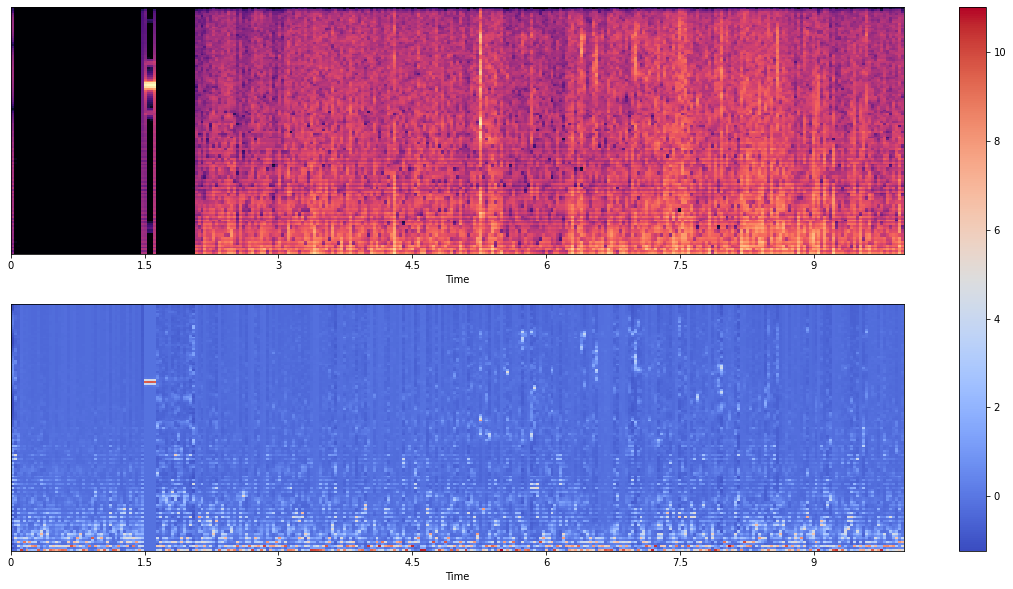

In [55]:
# Side-by-side comparison of Pure Mel Spectrogram and Normalised Mel Spectrogram, as shown in two figures

fig, ax = plt.subplots(2, figsize=(20, 10))

feat_ax = librosa.display.specshow(librosa.core.power_to_db(_segment_mel_spectrogram), sr=SAMPLE_RATE, x_axis='time', hop_length=HOP_LENGTH, ax=ax[0])
feat_norm_ax = librosa.display.specshow(_segment_mel_spectrogram_normalised, sr=SAMPLE_RATE, x_axis='time', hop_length=HOP_LENGTH, ax=ax[1])

plt.colorbar(feat_norm_ax, ax=ax)

plt.show()

## Voice Activty Detection (D. Ortiz P. et al., 2016)

### Dynamic threshold and Zero-crossing rate

In [20]:
# Max-and-min Zero Crossing Rate per window
# Equation taken from Wikipedia, adjusted with D. Ortiz P. et al. (2016)
_frames_zcr = []

for i in _frames:
    _frames_zcr.append(np.sum(np.abs(np.sign(i))) / i.shape[0])

_frames_zcr = np.array(_frames_zcr)

In [21]:
_zcr_min = _frames_zcr.min()
_zcr_max = _frames_zcr.max()
print(f'Min: {_zcr_min}, \nMax: {_zcr_max}')

Min: 5.654661565448734e-06, 
Max: 1.0


In [22]:
# Energy per window
_frames_energy = []
for i in _frames:
    _frames_energy.append(np.sqrt(np.sum(i**2) / i.shape[0]))

_frames_energy = np.array(_frames_energy)

In [23]:
_energy_min = _frames_energy.min()
_energy_mean = _frames_energy.mean()
print(f"Min: {_energy_min}, \nMean: {_energy_mean}")

Min: 1.0058764146652584e-06, 
Mean: 0.005786063260375177


In [28]:
_frames_energy[0]

0.004526851981989448

In [38]:
librosa_zcr.shape

(1, 12780)

In [24]:
np.diff(_emphasized_filtered_2, axis=0)

array([-0.00845335,  0.0136016 , -0.01681261, ..., -0.00021698,
        0.00074591, -0.00227856])

In [ ]:
# Calculating Lambda
_lambda_energy = (_energy_mean - _energy_min) / _energy_mean
_lambda_zcr = (_zcr_max - _zcr_min) / _zcr_max

# Calculating energy and ZCR threshold
# _threshold_energy = 